# 7. 데이터 준비하기: 다듬기, 변형, 병합

## 1. 데이터 합치기

- pandas 객체에 저장된 데이터는 여러 내장 함수를 이용해서 합칠 수 있다.

- pandas.merge는 하나 이상의 키를 기준으로 DataFrame의 로우를 합친다. SQL이나 다른 과계형 데이터 베이스의 join 연산과 유사하다.
- pandas.concat은 하나의 축을 따라 객체를 이어붙인다.
- combine_first 인스턴스 메서드는 두 객체를 포개서 한 객체에서 누락된 데이터를 다른 객체에 있는 값으로 채울 수 있도록 한다.

### 1) 데이터베이스 스타일로 DataFrame 합치기

- merge나 join 연산은 관계형 데이터베이스의 핵심적인 연산으로, 키를 하나 이상 사용해서 데이터 집합의 로우를 합친다.
- pandas의 merge함수를 이용해서 이런 알고리즘을 데이터에 적용할 수 있다.

In [3]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas
import pandas as pd
np.set_printoptions(precision=4, threshold=500)
pd.options.display.max_rows = 100

In [4]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'], 'data1': range(7)})

In [5]:
df2 = DataFrame({'key': ['a', 'b', 'd'], 'data2': range(3)})

In [6]:
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [7]:
df2

,data2,key
0,0,a
1,1,b
2,2,d


In [8]:
pd.merge(df1, df2)   #merge함수를 이용하여 df1과 df2를 merge (키값을 중심으로 data1,2를 가지고 온다. 겹치는 key값만 가지고 옴)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [9]:
pd.merge(df1, df2, on='key')   #merge와의 다른점은 merge는 겹치는 칼럼의 이름을 키로 사용하지만, 이 예에서처럼 명시적으로 하는것이 좋은예

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [10]:
df3 = DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'], 'data1': range(7)})

In [11]:
df4 = DataFrame({'rkey': ['a', 'b','d'], 'data2': range(3)})

In [12]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')   #두 객체에 공통되는 칼럼 이름이 하나도 없으면 따로 지정해주면 된다.

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


- 앞의 결과에서 보면 'c'와 'd'의 해당값이 빠진것을 볼 수 있다.
- merge함수의 경우엔 교집합인 결과를 반환
- how인자로 'left', 'right', 'outer를 넘겨서 각각 왼쪽, 오른쪽, 완전 외부 조인을 수행할 수 있다.

In [13]:
pd.merge(df1, df2, how='outer')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0
6,3,c,NaN
7,NaN,d,2


In [14]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'], 'data1': range(6)})

In [15]:
df2 = DataFrame({'key': ['a', 'b', 'a', 'b', 'd'], 'data2': range(5)})

In [16]:
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [17]:
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


In [18]:
pd.merge(df1, df2, on='key', how='left')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,2,a,0
5,2,a,2
6,3,c,NaN
7,4,a,0
8,4,a,2
9,5,b,1


- 다 대 다 조인은 두 로우의 데카르트 곱을 반환한다. 왼쪽 DataFrame 3개는 'b' 로우가 있고 오른쪽에는 2개의 'b'로우가 있는데, 결과는 6개의 'b'로우가 된다.
- 조인 메서드는 결과에 나타나는 구별되는 키에 대해서만 적용된다.

In [19]:
pd.merge(df1, df2, how='inner')   #다 대 다 조인은 두 로우의 데카르트 곱을 반환한다.

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


- 여러 개의 키를 병합하려면 칼럼 이름이 들어간 리스트를 넘기면 된다.

In [20]:
left = DataFrame({'key1': ['foo', 'foo', 'bar'],
                 'key2': ['one', 'two', 'one'],
                 'lval': [1,2,3]})

In [21]:
right = DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                 'key2': ['one', 'one', 'one', 'two'],
                 'rval': [4, 5, 6, 7]})

In [22]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1,4
1,foo,one,1,5
2,foo,two,2,NaN
3,bar,one,3,6
4,bar,two,NaN,7


- 칼럼과 칼럼을 조인할 때 전달한 DataFrame 객체의 색인은 무시된다.

- 머지 연산에서 고려해야 할 마지막 사항은 겹치는 칼럼 이름에 대한 처리이다.
- merge함수에 있는 suffixes 인자를 통해 겹치는 칼럼 이름 뒤에 붙일 문자열을 지정해 줄 수 있다.

In [23]:
pd.merge(left, right, on='key1')   #key1 값을 키값으로 하여 머지

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [24]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))    #key1 값을 키값으로 하여 suffixes 인자를 주어 머지 수행

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


### 2) 색인 머지하기

- 머지하려는 키가 DataFrame의 색인일 수 있다.
- 이때에는 left_index=True 혹은 right_index=True 옵션을 지정해 해당 색인을 머지 키로 사용할 수 있다.

In [25]:
left1 = DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                  'value': range(6)})
right1 = DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [26]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [27]:
right1

,group_val
a,3.5
b,7.0


In [28]:
pd.merge(left1, right1, left_on='key', right_index=True)   #right의 key값을 중심으로 merge를 수행한 결과

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [29]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')   #right를 키값을 중심으로 수행하되 외부조인한 결과

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


- 계층 색인된 데이터는 약간 복잡하다.

In [30]:
lefth = DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                   'key2': [2000, 2001, 2002, 2001, 2002],
                   'data': np.arange(5.)})
righth = DataFrame(np.arange(12).reshape((6, 2)),
                   index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
                          [2001, 2000, 2000, 2000, 2001, 2002]],
                   columns=['event1', 'event2'])
lefth

,data,key1,key2
0,0,Ohio,2000
1,1,Ohio,2001
2,2,Ohio,2002
3,3,Nevada,2001
4,4,Nevada,2002


In [31]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

- 이런 경우에는 리스트로 여러 개의 칼럼을 지정해서 머지해야한다.
- 중복된 색인 값을 다룰 때는 주의

In [32]:
pd. merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)   #right의 로우를 키값으로 머지 수행

,data,key1,key2,event1,event2
0,0,Ohio,2000,4,5
0,0,Ohio,2000,6,7
1,1,Ohio,2001,8,9
2,2,Ohio,2002,10,11
3,3,Nevada,2001,0,1


In [33]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')   #right의 로우를 키값으로 외부조인 수행

,data,key1,key2,event1,event2
0,0,Ohio,2000,4,5
0,0,Ohio,2000,6,7
1,1,Ohio,2001,8,9
2,2,Ohio,2002,10,11
3,3,Nevada,2001,0,1
4,4,Nevada,2002,NaN,NaN
4,NaN,Nevada,2000,2,3


- 양쪽에 공통으로 있는 여러 개의 색인을 머지하는 것은 일도 아니다.

In [34]:
left2 = DataFrame([[1., 2.], [3., 4.], [5., 6.]], index=['a', 'c', 'e'],
                 columns=['Ohio', 'Nevada'])
right2 = DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                   index=['b', 'c', 'd', 'e'], columns=['Missouri', 'Alabama'])

In [35]:
left2

,Ohio,Nevada
a,1,2
c,3,4
e,5,6


In [36]:
right2

,Missouri,Alabama
b,7,8
c,9,10
d,11,12
e,13,14


In [37]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1,2,NaN,NaN
b,NaN,NaN,7,8
c,3,4,9,10
d,NaN,NaN,11,12
e,5,6,13,14


- join 메서드를 사용하면 편리하다
- join 메서드는 칼럼이 겹치지 않으며 완전히 같거나 유사한 색인 구조를 가진 여러 개의 DataFrame 객체를 병합할 때 사용할 수 있다.

In [38]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1,2,NaN,NaN
b,NaN,NaN,7,8
c,3,4,9,10
d,NaN,NaN,11,12
e,5,6,13,14


In [39]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


- 색인 대 색인으로 두 DataFrame을 합치려면 그냥 간단한 머지하려는 DataFrame의 리스트를 join 메서드에 넘기면 된다.

In [40]:
another = DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                    index=['a', 'c', 'e', 'f'], columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7,8
c,9,10
e,11,12
f,16,17


In [41]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1,2,NaN,NaN,7,8
c,3,4,9,10,9,10
e,5,6,13,14,11,12


In [42]:
left.join([right2, another], how='outer')

,key1,key2,lval,Missouri,Alabama,New York,Oregon
0,foo,one,1,NaN,NaN,NaN,NaN
1,foo,two,2,NaN,NaN,NaN,NaN
2,bar,one,3,NaN,NaN,NaN,NaN
a,NaN,NaN,NaN,NaN,NaN,7,8
b,NaN,NaN,NaN,7,8,NaN,NaN
c,NaN,NaN,NaN,9,10,9,10
d,NaN,NaN,NaN,11,12,NaN,NaN
e,NaN,NaN,NaN,13,14,11,12
f,NaN,NaN,NaN,NaN,NaN,16,17


### 3) 축 따라 이어붙이기

- 데이터를 합치는 또 다른 방법으로는 이어붙이기, 연결, 적층 등이 있는데, Numpy는 ndarray를 연결하는 concatenate 함수를 제공

In [43]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [44]:
np.concatenate([arr, arr], axis=1)   #행을 기준, 0일경우 열을 기준

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

- Series나 DataFrame 같은 pandas 객체의 컨텍스트 내부에는 축마다 이름이 있어서 배열을 쉽게 이어붙일 수 있도록 되어 있다

In [45]:
s1 = Series([0, 1], index=['a', 'b'])
s2 = Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = Series([5, 6], index=['f', 'g'])

- pandas의 concat 함수는 이 사항에 대한 해답을 제공한다.
- 이 세 객체를 리스트로 묶어서 concat 함수에 전달하면 갑과 색인을 연결해준다.

In [46]:
pd.concat([s1, s2, s3])   #axis의 값은 0으로 되어있는 경우 Series가 된다.

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [47]:
pd.concat([s1, s2, s3], axis=1)   #axis의 값이 1인경우 DataFrame이 된다.

,0,1,2
a,0,NaN,NaN
b,1,NaN,NaN
c,NaN,2,NaN
d,NaN,3,NaN
e,NaN,4,NaN
f,NaN,NaN,5
g,NaN,NaN,6


- 겹치는 축이 없기 때문에 외부조인으로 정렬된 합집합을 얻었지만 join='inner'를 넘겨서 교집합을 구할 수 도 있다.

In [48]:
s4 = pd.concat([s1 * 5, s3])
s4

a    0
b    5
f    5
g    6
dtype: int64

In [49]:
pd.concat([s1, s4], axis=1)

,0,1
a,0,0
b,1,5
f,NaN,5
g,NaN,6


In [50]:
pd.concat([s1, s4], axis=1, join='inner')   #inner를 통해 교집합을 구함

,0,1
a,0,0
b,1,5


In [51]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])   #머지하려는 축을 직접 지정

,0,1
a,0,0
c,NaN,NaN
b,1,5
e,NaN,NaN


- Series를 이어붙이기 전의 개별 Series를 구분할 수 없다는 문제가 생기는데, 이 경우 이어붙인 축에 대해 계층적 색인을 생성하여 식별이 가능하도록 할 수 있다.
- 계층적 색인을 생성하려면 keys 인자를 사용하면 된다.

In [52]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [53]:
result.unstack()   #나중에 알아보자

,a,b,f,g
one,0,1,NaN,NaN
two,0,1,NaN,NaN
three,NaN,NaN,5,6


- Series는 axis=1로 병합할 경우 keys는 DataFrame의 칼럼 제목이 된다.

In [54]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0,NaN,NaN
b,1,NaN,NaN
c,NaN,2,NaN
d,NaN,3,NaN
e,NaN,4,NaN
f,NaN,NaN,5
g,NaN,NaN,6


- DataFrame에 대해서도 지금까지와 같은 방식으로 적용 가능

In [55]:
df1 = DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
                columns=['one', 'two'])
df2 = DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
                columns=['three', 'four'])
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])   #keys의를 다음과 같이 설정하여 df1, df2에 대해 concat수행

level1     level2     
     one two  three four
a      0   1      5    6
b      2   3    NaN  NaN
c      4   5      7    8

- 리스트 대신 객체의 사전을 넘긴다면 사전의 키가 keys 옵션으로 사용된다.

In [56]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1      5    6
b      2   3    NaN  NaN
c      4   5      7    8

In [57]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'], names=['upper', 'lower'])   #각 칼럼의 이름도 지정이 가능

upper level1     level2     
lower    one two  three four
a          0   1      5    6
b          2   3    NaN  NaN
c          4   5      7    8

- DataFrame의 로우 색인이 분석에 불필요한 경우에는 어떻게 할 것인가?

In [58]:
df1 = DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])

In [59]:
df1

,a,b,c,d
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221


In [60]:
df2

,b,d,a
0,0.274992,0.228913,1.352917
1,0.886429,-2.001637,-0.371843


- ignore_index = True 옵션을 주면 된다.

In [61]:
pd.concat([df1, df2])

,a,b,c,d
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
0,1.352917,0.274992,NaN,0.228913
1,-0.371843,0.886429,NaN,-2.001637


In [62]:
pd.concat([df1, df2], ignore_index=True)   #이어 붙이기 말고 불필요한 경우 다음과 같이 옵션을 주어 사용 가능

,a,b,c,d
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,1.352917,0.274992,NaN,0.228913
4,-0.371843,0.886429,NaN,-2.001637


### 4) 겹치는 데이터 합치기

- 데이터를 합칠 대 머지나 이어붙이기로는 불가능한 상왕의 경우 where 함수를 통해 해결이 가능

In [63]:
a = Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
           index=['f', 'e', 'd', 'c', 'b', 'a'])
b = Series(np.arange(len(a), dtype=np.float64),
           index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan

In [64]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [65]:
b

f     0
e     1
d     2
c     3
b     4
a   NaN
dtype: float64

In [66]:
np.where(pd.isnull(a), b, a)

array([ 0. ,  2.5,  2. ,  3.5,  4.5,  nan])

In [67]:
b[:-2].combine_first(a[2:])   #Series의 combine_first라는 메서드는 위와 동일한 연산을 제공, 데이터 정렬 기능까지 제공

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

- DataFrame에서도 combine_first 메서드는 사용 가능

In [68]:
df1 = DataFrame({'a': [1., np.nan, 5., np.nan],
                 'b': [np.nan, 2., np.nan, 6.],
                 'c': range(2, 18, 4)})
df2 = DataFrame({'a': [5., 4., np.nan, 3., 7.],
                 'b': [np.nan, 3., 4., 6., 8.]})
df1.combine_first(df2)

,a,b,c
0,1,NaN,2
1,4,2,6
2,5,4,10
3,3,6,14
4,7,8,NaN


## 재형성과 피벗

### 1) 계층적 색인으로 재형성하기

- stack : 데이터의 칼럼을 로우로 피벗 또는 회전시킨다.
- unstack : 로우를 칼럼으로 피벗시킨다.

In [69]:
data = DataFrame(np.arange(6).reshape((2, 3)),
                 index=pd.Index(['Ohio', 'Colorado'], name='state'),
                 columns=pd.Index(['one', 'two', 'three'], name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [70]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

In [71]:
result.unstack()   #unstack을 사용하면 계층적 색인을 DataFrame으로 얻어올 수 있다.

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [72]:
result.unstack(0)   #인자를 레벨 이름이나 숫자를 전달해 끄집어낼 단계를  지정할 수 있다.

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [73]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


- 해당 레벨에 있는 모든 값이 하위 그룹에 속하지 않을 경우 unstack을 하게 되면 누락된 데이터가 생길 수 있다.

In [74]:
s1 = Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s2 = Series([4, 5, 6], index=['c', 'd', 'e'])
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2.unstack()

,a,b,c,d,e
one,0,1,2,3,NaN
two,NaN,NaN,4,5,6


In [75]:
data2.unstack().stack()

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: float64

In [76]:
data2.unstack().stack(dropna=False)   #na값을 다시 살린 경우

one  a     0
     b     1
     c     2
     d     3
     e   NaN
two  a   NaN
     b   NaN
     c     4
     d     5
     e     6
dtype: float64

- DataFrame을 unstack()할 때, unstack() 레벨은 결과에서 가장 낮은 단계가 된다.

In [77]:
df = DataFrame({'left': result, 'right': result + 5},
               columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [78]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [79]:
df.unstack('state').stack('side')

state         Ohio  Colorado
number side                 
one    left      0         3
       right     5         8
two    left      1         4
       right     6         9
three  left      2         5
       right     7        10

### 2) 피버팅으로 데이터 나열 방식 바꾸기

- CSV 파일에 여러개의 시계열 데이터를 저장하는 일반적인 방법은 시간순으로 나열하는 방법이다.

In [80]:
data = pd.read_csv('https://raw.githubusercontent.com/pydata/pydata-book/master/ch07/macrodata.csv')
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')
data = DataFrame(data.to_records(),
                 columns=pd.Index(['realgdp', 'infl', 'unemp'], name='item'),
                 index=periods.to_timestamp('D', 'end'))

ldata = data.stack().reset_index().rename(columns={0: 'value'})
wdata = ldata.pivot('date', 'item', 'value')

In [81]:
ldata[:10]

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


- MySQL 같은 관계형 데이터베이스는 데이블에 데이터가 추가되거나 삭제되면 item 칼럼에 별게의 값을 넣거나 빼는 방식으로 고정된 스키마에 데이터를 저장
- 기본키가 관계무결성을 제공하며 쉬운 조인연산과 프로그램에 의한 질의를 가능하게 해준다
- DataFrame의 pivot 메서드가 이런 변형을 지원

In [82]:
pivoted = ldata.pivot('date', 'item', 'value')
pivoted.head()

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


- pivot 메서드의 처음 두 인자는 로우나 칼럼 색인으로 사용될 칼럼 이름이고 마지막 value는 DataFrame에 채워 넣을 값을 담고 있는 칼럼

In [83]:
ldata['value2'] = np.random.randn(len(ldata))
ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,1.669025
1,1959-03-31,infl,0.000,-0.438570
2,1959-03-31,unemp,5.800,-0.539741
3,1959-06-30,realgdp,2778.801,0.476985
4,1959-06-30,infl,2.340,3.248944
5,1959-06-30,unemp,5.100,-1.021228
6,1959-09-30,realgdp,2775.488,-0.577087
7,1959-09-30,infl,2.740,0.124121
8,1959-09-30,unemp,5.300,0.302614
9,1959-12-31,realgdp,2785.204,0.523772


- 마지막 인자를 생략해서 계층적 칼럼을 가지는 DataFrame을 얻을 수 있다.

In [84]:
pivoted = ldata.pivot('date', 'item')
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.438570  1.669025 -0.539741
1959-06-30  2.34  2778.801   5.1  3.248944  0.476985 -1.021228
1959-09-30  2.74  2775.488   5.3  0.124121 -0.577087  0.302614
1959-12-31  0.27  2785.204   5.6  0.000940  0.523772  1.343810
1960-03-31  2.31  2847.699   5.2 -0.831154 -0.713544 -2.370232

In [85]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


- pivot 메서드는 단지 set_index를 사용해서 계층적 색인을 만들고 unstack 메서드를 이용해서 형태를 변경하는 단축키 같은 메서드

In [86]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')
unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.438570  1.669025 -0.539741
1959-06-30  2.34  2778.801   5.1  3.248944  0.476985 -1.021228
1959-09-30  2.74  2775.488   5.3  0.124121 -0.577087  0.302614
1959-12-31  0.27  2785.204   5.6  0.000940  0.523772  1.343810
1960-03-31  2.31  2847.699   5.2 -0.831154 -0.713544 -2.370232
1960-06-30  0.14  2834.390   5.2 -0.860757 -1.860761  0.560145
1960-09-30  2.70  2839.022   5.6  0.119827 -1.265934 -1.063512

## 3. 데이터 변형

### 1) 중복 제거하기

- 여러 가지 이유로 DataFrame에서 중복된 로우를 발견할 수 있다.

In [87]:
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4,
                  'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


In [88]:
data.duplicated()   #duplicated 메서드는 각 로우가 중복인지 아닌지를 알려주는 불리언 Series 객체를 반환

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

In [89]:
data.drop_duplicates()   #duplicated에서 false인 dataFrame을 반환

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


In [90]:
data['v1'] = range(7)
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


In [91]:
data.drop_duplicates(['k1', 'k2'], take_last=True)   #take_last 옵션을 넘기면 마지막으로 발견된 값을 반환

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### 2) 함수나 매핑 이용해 데이터 변경하기

- 시리즈, 배열 안의 값을 기반으로하는 데이터의 형태를 변형하고 싶을 때 사용

In [92]:
data = DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
                           'corned beef', 'Bacon', 'pastrami', 'honey ham',
                           'nova lox'],
                  'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


In [93]:
meat_to_animal = {
  'bacon': 'pig',
  'pulled pork': 'pig',
  'pastrami': 'cow',
  'corned beef': 'cow',
  'honey ham': 'pig',
  'nova lox': 'salmon'
}

- Seires의 map 메서드는 사전류의 객체나 어떤 함수를 받을 수 있는데, 이 데이터는 육류의 이름에 대.소문자가 섞여 있는 사소한 문제가 있으므로 소문자로 모두 변경

In [94]:
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)   #map(str.lower)를 이용하여 소문자로 변경. 육류와 음식을 매핑
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


In [95]:
data['food'].map(lambda x: meat_to_animal[x.lower()])   #함수로 넘겨서 같은 일을 수행 가능

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

### 3) 값 치환하기

- replace 메서드는 같은 작업에 대해서 좀 더 간단하고 유연한 방법을 제공한다.

In [96]:
data = Series([1., -999., 2., -999., -1000., 3.])
data

0       1
1    -999
2       2
3    -999
4   -1000
5       3
dtype: float64

In [97]:
data.replace(-999, np.nan)   #-999값은 nan으로 치환

0       1
1     NaN
2       2
3     NaN
4   -1000
5       3
dtype: float64

In [98]:
data.replace([-999, -1000], np.nan)   #-999, -1000을 NaN으로 치환

0     1
1   NaN
2     2
3   NaN
4   NaN
5     3
dtype: float64

In [99]:
data.replace([-999, -1000], [np.nan, 0])   #-999는 NaN으로, -1000은 0으로

0     1
1   NaN
2     2
3   NaN
4     0
5     3
dtype: float64

In [100]:
data.replace({-999: np.nan, -1000: 0})   #사전을 이용해도 된다.

0     1
1   NaN
2     2
3   NaN
4     0
5     3
dtype: float64

###  4) 축 색인 이름 바꾸기

In [101]:
data = DataFrame(np.arange(12).reshape((3, 4)),
                 index=['Ohio', 'Colorado', 'New York'],
                 columns=['one', 'two', 'three', 'four'])

In [102]:
data.index.map(str.upper)   #인덱스는 대문자로

array(['OHIO', 'COLORADO', 'NEW YORK'], dtype=object)

In [103]:
data.index = data.index.map(str.upper)   #이런식으로 대입이 가능
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


- 대문자로 변경된 축 이름을 DataFrame의 index에 바로 대입할 수 있다.

In [104]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


- 원래 객체를 변경하지 않고 새로운 객체를 생성하려면 rename 메서드를 사용

In [105]:
data.rename(index={'OHIO': 'INDIANA'},
            columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [106]:
# Always returns a reference to a DataFrame
_ = data.rename(index={'OHIO': 'INDIANA'}, inplace=True)   #원본 데이터로 바로 변경하려면, inplace = True를 옵션으로 넘겨준다.
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### 5) 개별화와 양자화

In [107]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

- pandas의 cut 함수를 이용해서 그룹으로 나눌 수 있다.

In [108]:
bins = [18, 25, 35, 60, 100]
cats = pd.cut(ages, bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, object): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

- pandas에서 반환하는 객체는 Categorical 객체라는 특수한 객체인데, 이 객체는 그룹 이름이 담긴 배열이라고 생각하면 된다.
- labels 속성에 있는 ages데이터에 대한 카테고리 이름을 levels라는 배열에 내부적으로 담고 있다.

In [109]:
cats.labels

/Users/hyunkyo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/categorical.py:420: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  warnings.warn("'labels' is deprecated. Use 'codes' instead", FutureWarning)


array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [110]:
cats.categories

Index([u'(18, 25]', u'(25, 35]', u'(35, 60]', u'(60, 100]'], dtype='object')

In [111]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

- 간격을 나타내는 표기법은 괄호로 시작해서 대괄호로 끝나는데 괄호 쪽의 값은 포함하지 않고 대괄호 쪽의 값은 포함하는 간격을 나타낸다.
- right=False를 넘겨서 괄호와 대괄호의 위치를 바꿀수 있다.

In [112]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, object): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

In [113]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']   #labelse 옵션으로 그룹의 이름을 직접 넘겨 줄 수 있다.
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

- cut 함수에 명시적으로 그룹의 경계값을 넘기지 않고 그룹의 개수를 넘겨주면 데이터에서 최소 값과 최대 값을 기준으로 균등한 길이의 그룹의 자동으로 계산한다.

In [114]:
data = np.random.rand(20)
pd.cut(data, 4, precision=2)

[(0.45, 0.67], (0.23, 0.45], (0.0037, 0.23], (0.45, 0.67], (0.67, 0.9], ..., (0.67, 0.9], (0.0037, 0.23], (0.0037, 0.23], (0.23, 0.45], (0.23, 0.45]]
Length: 20
Categories (4, object): [(0.0037, 0.23] < (0.23, 0.45] < (0.45, 0.67] < (0.67, 0.9]]

- 이를 위한 가장 적합한 함수로 qcut이 있는데, 이는 표본 변위치를 기반으로 데이터를 나눠준다.
- cut 함수를 사용하게되념ㄴ 데이터 분산에 따라 각각의 그룹마다 데이터의 개수가 다르게 나누어지는 경우가 많다.
- qcut은 표준 변위치를 사용하기 때문에 적당히 같은 크기의 그룹으로 나눌 수 있다.

In [115]:
data = np.random.randn(1000) # Normally distributed
cats = pd.qcut(data, 4) # Cut into quartiles
cats

[(-0.022, 0.641], [-3.745, -0.635], (0.641, 3.26], [-3.745, -0.635], (-0.022, 0.641], ..., (-0.022, 0.641], (0.641, 3.26], (-0.635, -0.022], (0.641, 3.26], (-0.635, -0.022]]
Length: 1000
Categories (4, object): [[-3.745, -0.635] < (-0.635, -0.022] < (-0.022, 0.641] < (0.641, 3.26]]

In [116]:
pd.value_counts(cats)

(0.641, 3.26]       250
(-0.022, 0.641]     250
(-0.635, -0.022]    250
[-3.745, -0.635]    250
dtype: int64

In [117]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.])   #cut함수와 유사하게 변위치를 직접 지정해 줄수 있다.

[(-0.022, 1.302], (-1.266, -0.022], (-0.022, 1.302], [-3.745, -1.266], (-0.022, 1.302], ..., (-0.022, 1.302], (-0.022, 1.302], (-1.266, -0.022], (-0.022, 1.302], (-1.266, -0.022]]
Length: 1000
Categories (4, object): [[-3.745, -1.266] < (-1.266, -0.022] < (-0.022, 1.302] < (1.302, 3.26]]

### 6) 특이값 찾아내고 제외하기

In [118]:
np.random.seed(12345)
data = DataFrame(np.random.randn(1000, 4))
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


- DataFrame의 한 칼럼에서 절대 값이 3을 초과하는 값을 찾아내자

In [119]:
data

,0,1,2,3
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,0.274992,0.228913,1.352917,0.886429
4,-2.001637,-0.371843,1.669025,-0.438570
5,-0.539741,0.476985,3.248944,-1.021228
6,-0.577087,0.124121,0.302614,0.523772
7,0.000940,1.343810,-0.713544,-0.831154
8,-2.370232,-1.860761,-0.860757,0.560145
9,-1.265934,0.119827,-1.063512,0.332883


In [120]:
col = data[3]

In [121]:
col[np.abs(col) > 3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

In [122]:
data[(np.abs(data) > 3).any(1)]   #절대 값 3을 초과하는 값이 들어있는 모든 로우를 선택하려면 any 메서드를 활용

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [123]:
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()   #한번에 여러 개의 통계결과를 만들어 낸다.

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


### 7) 치환과 임의 샘플링

- numpy.random.permutation 함수를 이용하면 Series나 DataFrame의 로우를 쉽게 임의의 순서대로 재배치를 할 수 있다.
- 순서를 바꾸고 싶은 만큼의 길이를 permutation 함수에 넘기면 바뀐 순서가 담긴 정수 배열이 생성된다.

In [215]:
df = DataFrame(np.arange(5*4).reshape(5, 4))

In [216]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [217]:
sampler = np.random.permutation(5)   #sampler에 랜덤하게 5개의 수를 배열
sampler

array([1, 4, 2, 0, 3])

In [218]:
df.take(sampler)   #take를 사용하여 sampler의 배열에 따라 인덱스를 배치할 수 있다.

,0,1,2,3
1,4,5,6,7
4,16,17,18,19
2,8,9,10,11
0,0,1,2,3
3,12,13,14,15


- 치환 없이 일부만 선택하는 경우 permutation 함수에 반환된 배열에서 원하는 크기 k만큼만 처음부터 잘라내면 된다.

In [220]:
tmp = np.array([1,2])
tmp

array([1, 2])

In [221]:
df.take(tmp)

,0,1,2,3
1,4,5,6,7
2,8,9,10,11


- 치환하지 않고 표본을 수집하는 효과적인 알고리즘도 있지만, 손쉽게 사용할 수 있는 도구를 사용하는 간단한 방법이 있다.

In [128]:
df.take(np.random.permutation(len(df)))   #df의 길이만큼 랜덤하게 로우를 배열하는 방법

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19
0,0,1,2,3
2,8,9,10,11


- 치환을 통해 표본을 생성하기 위한 가장 빠른 방법은 np.random.randint를 사용해서 생성한 난수를 이용하는 방법

In [129]:
bag = np.array([5, 7, -1, 6, 4])

In [130]:
sampler = np.random.randint(0, len(bag), size=10)   #0부터 4까지 size 10까지 난수를 생성   len(bag)=5
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [131]:
draws = bag.take(sampler)
draws

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

### 8) 표시자/더미 변수

- 통계 모델이나 기계 학습 애플리케이션을 위한 또 다른 데이터 변형은 분류 값을 더미나 표시 행렬로 변환하는 것
- pandas의 get_dumies 함수는 한 칼럼에 k가지의 값이 있다면 k개의 칼림어 있는 DataFrame이나 행렬을 만들고 값으로는 1과 0을 채워 넣는 함수

In [132]:
df = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                'data1': range(6)})
df

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [133]:
pd.get_dummies(df['key'])   #key에 해당하는 칼럼을 중심으로 해당 인덱스에 b가 있었으면 1 아닌경우엔 0으로 채운다.

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


- 표시용 DataFrame 안에 있는 칼럼에 prefix를 추가한 후 다른 데이터와 병합하고 싶을 때가 있는데, 이런 경우 get_dummies 함수의 prefix 인자를 사용

In [134]:
dummies = pd.get_dummies(df['key'], prefix='key')
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [135]:
df_with_dummy = df[['data1']].join(dummies)   #join연산을 이용하여 df의 data1 값과 dummies의 값들을 join 한다.
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


- DataFrame의 한 칼럼이 여러 카테고리에 속한 경우
- MovieLens의 영화 데이터

In [226]:
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('https://raw.githubusercontent.com/pydata/pydata-book/master/ch02/movielens/movies.dat',
                       sep='::', header=None, names=mnames)   #해당 데이터를 read_table 함수로 읽어와 DataFrame으로 생성
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [225]:
type(movies)

pandas.core.frame.DataFrame

- 데이터 묶음에서 유일한 장르 목록을 추출해야 할 경우 set.union트릭을 사용

In [137]:
genre_iter = (set(x.split('|')) for x in movies.genres)   #movies DataFrame에서 장르 값들을 gere_iter에 저장
genres = sorted(set.union(*genre_iter))                   #*는 "어떤 파라미터를 몇개를 받을지 모르는 경우 사용한다"

In [138]:
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [139]:
dummies = DataFrame(np.zeros((len(movies), len(genres))), columns=genres)  #표시용 DataFrame을 생성하기 위해 0으로 초기화된 DataFrame을 생성
dummies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- 각 영화를 순회하면서 dummies 칼럼의 각 항목을 1로 설정

In [140]:
for i, gen in enumerate(movies.genres):     #입력값으로 시퀀스자료형(리스트, 튜플, 문자열)을 입력으로 받아 enumerate객체를 리턴
    dummies.ix[i, gen.split('|')] = 1       #각 영화를 순회하면서 dummies 칼럼의 각 항목을 1로 설정

In [141]:
dummies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


- 앞에서 한 대로 movies DataFrame과 조합하면 된다.

In [142]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))#movies_windic에 movies에 dummies의 값들을 join
movies_windic.ix[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Action                                   0
Genre_Adventure                                0
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Crime                                    0
Genre_Documentary                              0
Genre_Drama                                    0
Genre_Fantasy                                  0
Genre_Film-Noir                                0
Genre_Horror                                   0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Romance                                  0
Genre_Sci-Fi                                   0
Genre_Thriller                                 0
Genre_War                                      0
Genre_Western       

In [143]:
movies_windic.head()

,movie_id,title,genres,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,...,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


> 데이터가 이보다 더 크다면 다중 멤버십을 갖는 표시용 변수를 이 방법으로 생성하는 것은 그다지 빠른 방법은 아니다.
> 빠르게 처리하고 싶다면 DataFrame의 내부를 짝하는 저수준의 함수를 작성해서 사용해야 한다.

- get_dummies나 cut 같은 이산 함수를 잘 조합하면 통계 애플리케이션에서 유용하게 사용할 수 있다.

In [144]:
values = np.random.randn(10)
values

array([ 0.325 ,  0.2038,  0.3489,  0.516 , -0.4898, -0.6287,  0.2664,
        1.0837,  0.3033, -1.1072])

In [145]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [146]:
pd.get_dummies(pd.cut(values, bins))
#cut함수를 이용하여 bins의 값을 이용하여 5개의 카테고리를 생성하고 dummies를 이용하여 values값이 속한곳에 1을 표시

,"(0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]"
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,1,0,0,0
7,0,0,0,0,0
8,0,1,0,0,0
9,0,0,0,0,0


## 4. 문자열 다루기

### 1) 문자열 객체 메서드

In [147]:
val = 'a, b,  guido'

In [148]:
val.split(',')    #문자열을 구분하는 구분자를 일반적으로 split 함수를 사용

['a', ' b', '  guido']

In [149]:
pieces = [x.strip() for x in val.split(',')]   #split 메서드는 종종 공백문자를 제거하는 strip 메서드와 조합해서 사용
pieces

['a', 'b', 'guido']

In [150]:
first, second, third = pieces
first + '::' + second + '::' + third   #분리된 문자열은 더하기 연산을 통해 '::' 문자열과 합칠 수도 있다.

'a::b::guido'

- 위의 방법은 실용적이거나 범용적인 메서드는 아니다.
- 빠르고 좀 더 파이썬스러운 방법은 리스트나 튜플을 '::' 문자열의 join 메서드에 전달하는 것

In [151]:
'::'.join(pieces)

'a::b::guido'

- 일치하는 부분의 문자열의 위치를 찾는 방법도 있다.
- index나 find를 사용하는 것도 가능하지만 파이썬의 in 예약어를 사용하면 일치하는 부분 문자열을 쉽게 찾을 수 있다.

In [229]:
val

'a, b,  guido'

In [152]:
'guido' in val   #guido가 val안에 있는가?

True

In [238]:
val.index(',')   #index의 경우 문자열을 찾지 못하면 예외를 발생 시킴, 있는 경우 해당 위치를 반환

1

In [154]:
val.find(':')    #find의 경우 없으면 -1을 반환

-1

In [155]:
val.count(',')   #특정 문자열이 몇 건 발견되었는지를 반환

2

In [156]:
val.replace(',', '::')   #val의 쉼표를 '::'으로 대체하여 반환

'a:: b::  guido'

In [157]:
val.replace(',', '')    #val의 쉼표 구분을 아무것도 안하게 반환

'a b  guido'

### 2) 정규표현식

- 정규표현식은 특정한 규칙을 가진 문자열의 집합을 표현하는 데 사용하는 형식 언어이다.
- 정규표현식은 텍스트에서 문자열 패터을 찾는 유연한 방법을 제공한다.
- 흔히 regex라 불리는 단일 표현식은 정규표현언어로 구성된 문자열이다.
- 파이썬에는 re 모듈이 내장되어 문자열에 대한 정규표현식을 처리한다.
- re 모듈 함수는 패턴 매칭, 치환, 분리의 세 가지로 나눌 수 있다.
- 정규표현식은 텍스트 안에 존재하는 패턴을 표현하고 이를 여러가지 다양한 목적으로 사용할 수 있도록 되어있다.

In [240]:
import re

In [241]:
text = "foo   bar\t baz   \tqux"

In [242]:
text

'foo   bar\t baz   \tqux'

In [243]:
re.split('\s+', text)   #공백이 여러가지 있을 수 있기 때문에 \s+로 구분을 할 수 있도록 한다.

['foo', 'bar', 'baz', 'qux']

- 위와 같이 수행하면 정규표현식이 컴파일되고 그 다음에 split메서드가 실행된다.
- re.compile을 통해 직접 정규표현식을 컴파일하고 그렇게 얻은 정규표현식 객체를 재사용하는 것도 가능하다.
- re.compile을 이용해서 정규표현식 객체를 만들어 사용하는 방법은 CPU 사용량을 아낄 수 있다.

In [244]:
regex = re.compile('\s+')

In [245]:
regex

re.compile(r'\s+')

In [246]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

- 정규표현식에 매칭되는 모든 패턴의 목록을 얻고 싶다면 findall 메서드를 사용

In [247]:
regex.findall(text)

['   ', '\t ', '   \t']

- match와 search는 findall 메서드와 관련이 있다.
- findall은 문자열에서 일치하는 모든 부분의 문자열을 찾아주지만, search 메서드는 패턴과 일치하는 첫 번째 존재를 반환
- match는 이보다 더 엄격해서 문자열의 시작 부분에서 일치하는 것만 찾아준다.

In [249]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE는 정규표현식이 대.소문자를 가리지 않도록 한다.
regex = re.compile(pattern, flags=re.IGNORECASE)

In [250]:
regex.findall(text)   #findall을 사용하여 이메일 주소 리시트를 생성

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [253]:
m = regex.search(text)   #search는 텍스트에서 첫 번째 이메일 주소만 찾아준다. 'dave@google.com'
m

In [254]:
text[m.start():m.end()]   #m의 첫 번째 이메일 주소중 처음 문자부터 마지막 문자까지를 출력

'dave@google.com'

In [255]:
text[m.start()]   #처음과 끝 문자를 출력

'd'

In [256]:
text[m.end()]

'\n'

In [266]:
print regex.match(text)   #None을 반환하는 이유는 패턴이 문자열의 시작점에서부터 일치하는지 검사하기 때문

None


In [258]:
print regex.sub('REDACTED', text)   #sub메서드는 찾은 패턴을 주어진 문자열로 치환하여 새로운 문자열을 반환

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



- 이메일 주소를 찾아서 동시에 각 이메일 주소를 사용자 이름, 도메인 이름, 도메인 접미사의 세 가지 컴포턴트로 나누어야 한다면 각 패터을 괄호로 묶어준다.

In [259]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

In [261]:
print pattern
print regex

([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})


- 이렇게 만든 match 객체를 이용하면 group 메서드를 통해 각 패턴 컴포넌트의 튜플을 얻을 수 있다.

In [267]:
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

In [268]:
regex.findall(text)   #패턴에 그룹이 있다면 findall 메서드는 튜플의 목록을 반환

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

In [269]:
print regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text)
#sub역시 마찬가지로 \1, \2 같은 특수 기호를 사용해서 패턴의 그룹에 접근 가능

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



- 이메일 주소 정규표현식의 매치 그룹에 다음처럼 이름을 줄 수도 있다.

In [178]:
regex = re.compile(r"""
    (?P<username>[A-Z0-9._%+-]+)
    @
    (?P<domain>[A-Z0-9.-]+)
    \.
    (?P<suffix>[A-Z]{2,4})""", flags=re.IGNORECASE|re.VERBOSE)   #re.VERBOSE를 사용하면 문자열의 whitespace는 컴파일시 제거

In [179]:
m = regex.match('wes@bright.net')   #정규표현식으로 생성한 match 객체는 그룹 이름이 지정되어 편리한 사전형을 만들어 준다.
m.groupdict()

{'domain': 'bright', 'suffix': 'net', 'username': 'wes'}

### 3) pandas의 백터화된 문자열 함수

- 데이터 분석시 뒤죽박죽인 데이터의 문자열을 다듬고 정규화 하는 정리 작업이 필요
- 문자열을 담고 있는 칼럼에 누락된 값이 있다면 일을 더 복잡하게 만든다

In [271]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com',
        'Rob': 'rob@gmail.com', 'Wes': np.nan}
data = Series(data)
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [272]:
data.isnull()   #null값이 들어가 있는 칼럼이 있는지 확인

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

In [273]:
data.str.contains('gmail')   #data의 str중에 gmail을 포함하고 있는 문자열이 있는지 확인

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [274]:
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z]{2,4})'

In [275]:
data.str.findall(pattern, flags=re.IGNORECASE)   #IGNORECASE와 같은 re옵션과 함께 정규표현식도 사용할 수 있다.

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

- 벡터화된 요소를 꺼내오는 몇가지 방법, str.get을 이용하거나 str 속성의 색인을 이용하는 방법 두가지

In [276]:
matches = data.str.match(pattern, flags=re.IGNORECASE)
matches

Dave     (dave, google, com)
Rob        (rob, gmail, com)
Steve    (steve, gmail, com)
Wes                      NaN
dtype: object

In [277]:
matches.str.get(1)   #해당 행에서 튜플에 들어있는 문자열들 중에 두번째 문자열(그룹)을 반환 하도록

Dave     google
Rob       gmail
Steve     gmail
Wes         NaN
dtype: object

In [278]:
matches.str[0]    #해당 행에서 튜플에 들어있는 문자열들 중에 첫 번째 이름에 해당하는 문자열(그룹)을 반환 하도록

Dave      dave
Rob        rob
Steve    steve
Wes        NaN
dtype: object

In [279]:
data.str[:5]   #해당 방법으로 문자열을 잘라 낼 수도 있다.

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

## 5. 예제: 미국 농무부 음식 데이터베이스

- 미국 농무부는 음식의 영양소 정보 데이터베이스를 제공하고 있다.
- 영구 해커인 에슐리 윌리엄스는 이 데이터베이스를 다음과 같은 JSON 형식으로 웹사이트*에 제공하고 있다.

In [280]:
import json
import urllib
db = json.load(urllib.urlopen('https://raw.githubusercontent.com/pydata/pydata-book/master/ch07/foods-2011-10-03.json'))
len(db)

6636

- db에 있는 각 엔트리는 한 가지 음식에 대한 모든 정보를 담고 있는 사전형이다.
- 'nutrients' 필드는 사전의 리스트이며 각 항목은 한 가지 영양소에 대한 정보를 담고 있다.

In [287]:
db[0]

{u'description': u'Cheese, caraway',
 u'group': u'Dairy and Egg Products',
 u'id': 1008,
 u'manufacturer': u'',
 u'nutrients': [{u'description': u'Protein',
   u'group': u'Composition',
   u'units': u'g',
   u'value': 25.18},
  {u'description': u'Total lipid (fat)',
   u'group': u'Composition',
   u'units': u'g',
   u'value': 29.2},
  {u'description': u'Carbohydrate, by difference',
   u'group': u'Composition',
   u'units': u'g',
   u'value': 3.06},
  {u'description': u'Ash', u'group': u'Other', u'units': u'g', u'value': 3.28},
  {u'description': u'Energy',
   u'group': u'Energy',
   u'units': u'kcal',
   u'value': 376.0},
  {u'description': u'Water',
   u'group': u'Composition',
   u'units': u'g',
   u'value': 39.28},
  {u'description': u'Energy',
   u'group': u'Energy',
   u'units': u'kJ',
   u'value': 1573.0},
  {u'description': u'Fiber, total dietary',
   u'group': u'Composition',
   u'units': u'g',
   u'value': 0.0},
  {u'description': u'Calcium, Ca',
   u'group': u'Elements',
   

In [285]:
db[0].keys()

[u'portions',
 u'description',
 u'tags',
 u'nutrients',
 u'group',
 u'id',
 u'manufacturer']

In [288]:
db[0]['nutrients'][1]

{u'description': u'Total lipid (fat)',
 u'group': u'Composition',
 u'units': u'g',
 u'value': 29.2}

In [289]:
nutrients = DataFrame(db[0]['nutrients'])
nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


- 사전의 리스트를 DataFrame으로 바꿀 때 추출할 필드 목록을 지정해줄 수 있다. 우리는 음식의 이름과 그룹, id 그리고 제조사를 추출할 것이다.

In [290]:
info_keys = ['description', 'group', 'id', 'manufacturer']

In [291]:
info = DataFrame(db, columns=info_keys)

In [292]:
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [293]:
info

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


In [294]:
pd.value_counts(info.group)[:10]   #info의 group 열을 value_counts메서드를 이용해서 음식 그룹의 분포를 확인

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
dtype: int64

- 쉽게 분석 하기 위해 각 음식의 영양소 정보를 거대한 테이블 하나에 담는다.
- 사전에 몇 가지 과정을 거쳐야 하는데 먼저 음식의 영양소 리스트를 하나의 DataFrame으로 변환하고, 음식의 id를 위한 칼럼을 추가
- DataFrame을 리스트에 추가한다. 마지막으로 리스트를 concat 메서드를 사용해서 하나로 합친다.

In [198]:
nutrients = []

for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

nutrients = pd.concat(nutrients, ignore_index=True)   #인덱스 값을 무시

In [199]:
nutrients

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


In [200]:
nutrients.duplicated().sum()   #중복된 데이터의 갯수를 알아본다.

14179

In [201]:
nutrients = nutrients.drop_duplicates()   #drop_duplicates 메서드를 이용하여 중복된 데이터를 제거

In [202]:
nutrients

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


- group과 description은 모두 DataFrame 객체이므로 뭐가 뭔지 쉽게 알아볼 수 있도록 이름을 바꾼다.

In [203]:
col_mapping = {'description' : 'food',
               'group' : 'fgroup'}

In [204]:
info = info.rename(columns=col_mapping, copy=False)
info

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


In [205]:
col_mapping = {'description' : 'nutrient',
               'group' : 'nutgroup'}

In [206]:
nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


- info 객체를 nutrients 객체로 병합한다.

In [207]:
ndata = pd.merge(nutrients, info, on='id', how='outer')   #key를 'id'로 하여 외부 조인으로 병합
ndata

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.180,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.200,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.060,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.280,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.000,1008,"Cheese, caraway",Dairy and Egg Products,
5,Water,Composition,g,39.280,1008,"Cheese, caraway",Dairy and Egg Products,
6,Energy,Energy,kJ,1573.000,1008,"Cheese, caraway",Dairy and Egg Products,
7,"Fiber, total dietary",Composition,g,0.000,1008,"Cheese, caraway",Dairy and Egg Products,
8,"Calcium, Ca",Elements,mg,673.000,1008,"Cheese, caraway",Dairy and Egg Products,
9,"Iron, Fe",Elements,mg,0.640,1008,"Cheese, caraway",Dairy and Egg Products,


In [208]:
ndata.ix[30000]   #30000 로우의 해당 값들을 반환

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

- 음식 그룹과 영양소의 종류별 중간 값을 그래프로 그려낼 수 있다.

In [209]:
%matplotlib inline

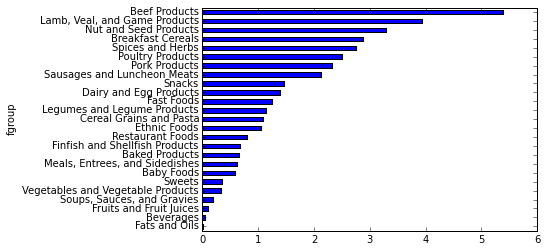

In [210]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].order().plot(kind='barh')   #영양소 그룹에 따른 아연 함유량에 대한 그래프

- 좀 더 응용하면 각 영양소가 어떤 음식에 가장 많이 들어있는지 찾아볼 수도 있다.

In [211]:
#ndata는 info와 nutrients 정보를 합친것으로 nutgroup과 nutrient를 그룹화 한다.
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.xs(x.value.idxmax())   #람다 함수를 이용하여 해당 가장 큰 값과 가장 작은 값을 찾아낸다.
get_minimum = lambda x: x.xs(x.value.idxmin())

max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

# make the food a little smaller
max_foods.food = max_foods.food.str[:50]   #max_food에 문자 50자까지 food에 넣는다.

In [212]:
max_foods.ix['Amino Acids']['food']   #아미노산이 들어있는 영양소 그룹의 food 정보를 보여준다.

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 

In [213]:
by_nutrient

In [214]:
max_foods

value  \
nutgroup    nutrient                                         
Amino Acids Alanine                                  8.009   
            Arginine                                 7.436   
            Aspartic acid                           10.203   
            Cystine                                  1.307   
            Glutamic acid                           17.452   
            Glycine                                 19.049   
            Histidine                                2.999   
            Hydroxyproline                           0.803   
            Isoleucine                               4.300   
            Leucine                                  7.200   
            Lysine                                   6.690   
            Methionine                               1.859   
            Phenylalanine                            4.600   
            Proline                                 12.295   
            Serine                                   4.600   
            Threonine                                3.300   
            Tryptophan                               1.600   
            Tyrosine                                 3.300   
            Valine                                   4.500   
Composition Adjusted Protein                        12.900   
            Carbohydrate, by difference            100.000   
            Fiber, total dietary                    79.000   
            Protein                                 88.320   
            Sugars, total                           99.800   
            Total lipid (fat)                      100.000   
            Water                                  100.000   
Elements    Calcium, Ca                           7364.000   
            Copper, Cu                              15.050   
            Fluoride, F                            584.000   
            Iron, Fe                                87.470   
            Magnesium, Mg                          781.000   
            Manganese, Mn                          133.000   
            Phosphorus, P                         9918.000   
            Potassium, K                         16500.000   
            Selenium, Se                          1917.000   
            Sodium, Na                           27360.000   
            Zinc, Zn                                90.950   
Energy      Energy                                3774.000   
Other       Alcohol, ethyl                          42.500   
            Ash                                     72.500   
            Beta-sitosterol                        426.000   
            Caffeine                              3680.000   
            Campesterol                            241.000   
            Cholesterol                           3100.000   
            Fatty acids, total monounsaturated      83.689   
            Fatty acids, total polyunsaturated      66.000   
            Fatty acids, total saturated            95.600   
            Fatty acids, total trans                20.578   
            Fatty acids, total trans-monoenoic      18.970   
            Fatty acids, total trans-polyenoic       3.543   
            Phytosterols                          9060.000   
            Stigmasterol                            38.000   
            Theobromine                           2634.000   
Sugars      Fructose                                42.830   
            Galactose                                5.620   
            Glucose (dextrose)                      57.000   
            Lactose                                 56.000   
            Maltose                                 10.430   
            Starch                                  73.770   
            Sucrose                                 99.800   
Vitamins    Betaine                                630.400   
            Carotene, alpha                      14251.000   
            Carotene, beta                       42891.000   
            Choline, to